### Exercise project_5 KNN ML model. I will use a dataset from Exercise_project_4 - "Student Alcohol Consumption" (https://www.kaggle.com/datasets/uciml/student-alcohol-consumption?resource=download). There are two datasets, I will combine them into one (Portuguese language course, Math course). I will clean the dataset a bit more, so there will not be much noisy. The target variable is "High_alcohol_use". Before cleaning  - 1044 rows, 33 columns. After cleaning - 218, columns - 11. Random forest ML model  accuracy - 81.11%.

In [2653]:
 # usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline

# since we're doing KNN-classification:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Cleaning and optimizing the dataset:

In [2654]:
# load data 
df_por = pd.read_csv("student-por.csv")
df_mat = pd.read_csv("student-mat.csv")


In [2655]:
# Example: combining two datasets with the same structure
df = pd.concat([df_mat, df_por], ignore_index=True)

In [2656]:
df.describe()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [2657]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [2658]:
len(df.columns)

33

In [2659]:
# check for dublicates:
df.duplicated().sum()

0

In [2660]:
# check for missing values 
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

#### I will create target variable "High_alcohol_use" based on Dalc and Walc variables (workday/weekend alcohol consumption 1-5). This dataset uses the following scale: 1 – very low, 2 – low, 3 – average, 4 – high, 5 – very high. If a student's average score is above 3, it indicates high alcohol consumption. 

In [2661]:
df["Dalc"].value_counts()


Dalc
1    727
2    196
3     69
5     26
4     26
Name: count, dtype: int64

In [2662]:
df["Walc"].value_counts()

Walc
1    398
2    235
3    200
4    138
5     73
Name: count, dtype: int64

In [2663]:
# creating a new variable based on  Dalc and Walc variables:
df['high_alcohol_use'] = ((df['Walc'] + df['Dalc']) / 2 > 3).map({True: 1, False: 0})

In [2664]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,high_alcohol_use
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,0
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,0


In [2665]:
# check the distribution of the target variable
# not balanced variable, the same problem as in the previous dataset. To avoid overfitting, I will implement downsampling, 
# meaning will remove some of the catergory 0.
df["high_alcohol_use"].value_counts()


high_alcohol_use
0    935
1    109
Name: count, dtype: int64

In [2666]:
from sklearn.utils import resample

# partical downsampling. To have successfull KNN model the target variable should be balanced. In Exersice_project_4 i did downsamling to 
# in following way: 400(0) -109(1) and 250(0) - 109(1).
# In this case I will downsample 109(1) to 109(0), so the data will be balanced. The total amount of rows will be 218. Let's try it.
# Step 1: Separate classes
majority = df[df['high_alcohol_use'] == 0]  
minority = df[df['high_alcohol_use'] == 1] 

# Step 2: Downsample majority to 400
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=109,  # to match minority
    random_state=42
)

# Step 3: Combine downsampled majority with full minority
df = pd.concat([majority_downsampled, minority])

In [2667]:
df["high_alcohol_use"].value_counts()

high_alcohol_use
0    109
1    109
Name: count, dtype: int64

In [2668]:
df.reset_index(drop=True, inplace=True)

In [2669]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,high_alcohol_use
0,MS,F,18,U,GT3,T,3,3,services,services,...,3,4,1,1,5,0,10,9,9,0
1,GP,M,15,U,GT3,T,4,0,teacher,other,...,4,3,1,1,1,8,11,11,10,0
2,GP,M,17,U,GT3,T,4,4,teacher,teacher,...,5,5,1,3,2,14,11,9,9,0
3,GP,F,16,U,GT3,T,4,3,health,other,...,3,5,1,5,2,2,14,14,15,0
4,GP,M,18,U,LE3,T,3,4,services,other,...,3,3,1,3,5,6,16,16,17,0


In [2670]:
# checking support variables:
df["sex"].value_counts()

sex
M    138
F     80
Name: count, dtype: int64

In [2671]:
# R - means rural, U - means urban, we can use rural addresses as it may effect the alcohol use
df["address"].value_counts()

address
U    152
R     66
Name: count, dtype: int64

In [2672]:
#'LE3' - less or equal to 3 or 'GT3' - greater than 3
df["famsize"].value_counts()

famsize
GT3    139
LE3     79
Name: count, dtype: int64

In [2673]:
# 'T' - living together or 'A' - apart
df["Pstatus"].value_counts()

Pstatus
T    188
A     30
Name: count, dtype: int64

In [2674]:
df["guardian"].value_counts()

guardian
mother    149
father     52
other      17
Name: count, dtype: int64

In [2675]:
# use of OneHotEncoder for "guardian" column , it will create multiple columns with numeric values:
from sklearn.preprocessing import OneHotEncoder
variables = ["guardian"]
             
# use encoder:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [2676]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Walc,health,absences,G1,G2,G3,high_alcohol_use,guardian_father,guardian_mother,guardian_other
0,MS,F,18,U,GT3,T,3,3,services,services,...,1,5,0,10,9,9,0,1,0,0
1,GP,M,15,U,GT3,T,4,0,teacher,other,...,1,1,8,11,11,10,0,0,1,0
2,GP,M,17,U,GT3,T,4,4,teacher,teacher,...,3,2,14,11,9,9,0,0,1,0
3,GP,F,16,U,GT3,T,4,3,health,other,...,5,2,2,14,14,15,0,0,1,0
4,GP,M,18,U,LE3,T,3,4,services,other,...,3,5,6,16,16,17,0,0,1,0


In [2677]:
# next we will remove one new boolean variable "guardian_other" (since it's going to be represented
# by a straight line of zeroes)
df = df.drop("guardian_other", axis=1)

In [2678]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2', 'G3', 'high_alcohol_use',
       'guardian_father', 'guardian_mother'],
      dtype='object')

In [2679]:
#  extra educational support, the same binary yes/not for "famsup"- family educational support ,
# "paid" - extra paid classes within the course subject, "activities" - extra-curricular activities,
# "nursery"- attended nursery school,'higher', 'internet', 'romantic'
df["schoolsup"].value_counts()

schoolsup
no     202
yes     16
Name: count, dtype: int64

In [2680]:
# now we will use LabelEncoder to converts the value of column to 0 or 1 for such columns that have just 2 unique values

from sklearn.preprocessing import LabelEncoder
# list of all boolean variables we want to convert
variables = ['sex', "address","famsize","Pstatus","schoolsup","famsup","paid","activities",
             "nursery","higher","internet","romantic"]

# initalize encoder and convert everything
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [2681]:
# "famrel" - quality of family relationships (numeric: from 1 - very bad to 5 - excellent),
# the same values for "freetime" - free time after school, "goout" - going out with friends,
# "health" - current health status.
df["famrel"].value_counts()

famrel
4    103
5     65
3     29
2     13
1      8
Name: count, dtype: int64

In [2682]:
# drop not needed columns ("Mjob","Fjob" - job of mother and father, 
# these variable may effect the alcohol use, but we have to many columns; "reason" - reason for choosing the school, )
columns_to_drop = ["Dalc",
                   "Walc",
                   "G1",
                   "G2",
                   "G3",
                   "school",
                   "Mjob",
                   "Fjob",
                   "reason"

]
df = df.drop(columns_to_drop, axis=1)

In [2683]:
len(df.columns)

26

In [2684]:
df.head(5)

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,...,internet,romantic,famrel,freetime,goout,health,absences,high_alcohol_use,guardian_father,guardian_mother
0,0,18,1,0,1,3,3,1,2,0,...,0,1,5,3,4,5,0,0,1,0
1,1,15,1,0,1,4,0,2,4,0,...,1,0,3,4,3,1,8,0,0,1
2,1,17,1,0,1,4,4,1,2,0,...,1,1,4,5,5,2,14,0,0,1
3,0,16,1,0,1,4,3,1,2,0,...,1,0,4,3,5,2,2,0,0,1
4,1,18,1,1,1,3,4,1,2,0,...,1,1,4,3,3,5,6,0,0,1


####  Now, all columns contain only numeric values. In total, there are 26 columns. Next, I will check the data distribution and correlation.

### Visualising the Data.

<Axes: >

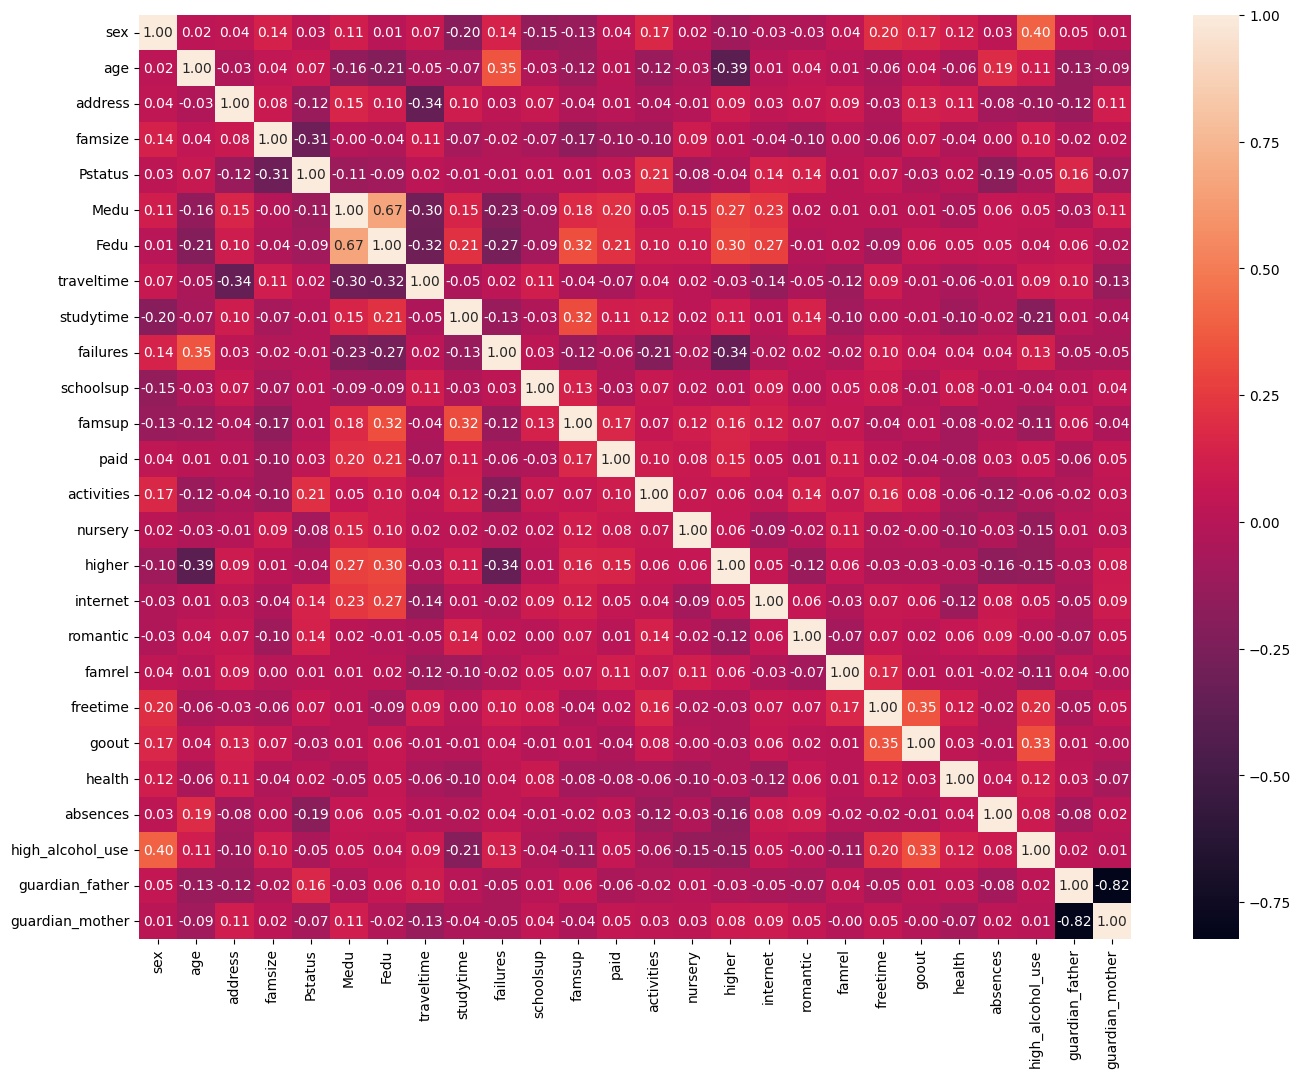

In [2685]:
# it was difficult to see numbers, so we will increase the figure size:
plt.figure(figsize=(16, 12))

# on this correlation matrix we can see the most important supported variables:
# median_income. Also, "ocean_proximity_<1H OCEAN" variale correlate with out target variable and
# "ocean_proximity_INLAND" has negative correlation. 
correlations = df.corr(numeric_only=True)
sns.heatmap(correlations, annot=True, fmt='.2f')

#### From correlation matrix we can see that "sex","famsize""failures","goout", "studytime"(negative corr),"higher"(negative corr), "freetime" and "absences" variables have the highest correlation with "high_alcohol_use"

###  X/y and train/test split

In [2686]:
# a small trick => use everything else except, the target
X = df.drop("high_alcohol_use", axis=1)

# our target variable is y
y = df['high_alcohol_use']

### Cheking for multicollinearity:

In [2687]:
# here I will check variables for multicollinearity:
# Finding columns with potential multicollinearity (VIF-test)
# pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
# VIF = Variance Inflation Factor
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  

# variables with high VIF-value 
# can mean multlicollinearity (variables providing same linear
# relationships in the data, confusing the logistic regression
print(vif_data)

            feature        VIF
0               sex   3.736667
1               age  58.178032
2           address   4.321351
3           famsize   1.968008
4           Pstatus  10.345310
5              Medu  14.436412
6              Fedu  13.351979
7        traveltime   6.199799
8         studytime   7.303679
9          failures   1.700035
10        schoolsup   1.275481
11           famsup   3.220097
12             paid   1.468764
13       activities   2.958411
14          nursery   5.103303
15           higher   9.466603
16         internet   6.514308
17         romantic   1.791926
18           famrel  18.674964
19         freetime  13.802316
20            goout  12.277810
21           health   8.487867
22         absences   1.849066
23  guardian_father   4.295625
24  guardian_mother   9.813750


#### Based on VIF value, correlation and target i will drop "age", "address","schoolsup","famsup","paid","activities", "nursery", "internet", "romantic", "famrel","Medu","Fedu", and "guardian_mother", "guardian_father"

In [2688]:
columns_to_drop_after_VIF = [
                   "age",
                   "address",
                   "schoolsup",
                   "famsup",
                   "paid",
                   "activities",
                   "nursery",
                   "internet",
                   "romantic",
                   "Medu",
                   "Fedu",
                   "famrel",
                   "guardian_father",
                   "guardian_mother"

]
df = df.drop(columns_to_drop_after_VIF, axis=1)

In [2689]:
# a small trick => use everything else except, the target
X = df.drop("high_alcohol_use", axis=1)

# our target variable is y
y = df['high_alcohol_use']

In [2690]:
# here I will check variables for multicollinearity:
# Finding columns with potential multicollinearity (VIF-test)
# pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
# VIF = Variance Inflation Factor
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  

# variables with high VIF-value 
# can mean multlicollinearity (variables providing same linear
# relationships in the data, confusing the logistic regression
print(vif_data)

       feature        VIF
0          sex   3.117896
1      famsize   1.743342
2      Pstatus   6.802801
3   traveltime   4.556370
4    studytime   5.305945
5     failures   1.366645
6       higher   6.979102
7     freetime  11.828246
8        goout  10.366146
9       health   6.809929
10    absences   1.575716


#### there is freetime and goout variables may relate to each other. I will drop freetime one as it correlate not as strong as goout with the target. 

In [2691]:
df = df.drop("freetime", axis=1)


In [2692]:
df.describe()

,sex,famsize,Pstatus,traveltime,studytime,failures,higher,goout,health,absences,high_alcohol_use
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,0.633028,0.362385,0.862385,1.651376,1.775229,0.353211,0.866972,3.587156,3.655963,5.500000,0.500000
std,0.483088,0.481796,0.345288,0.857347,0.820212,0.749202,0.340386,1.208350,1.435555,7.324128,0.501151
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,3.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,4.000000,4.000000,4.000000,0.500000
75%,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,1.000000,5.000000,5.000000,8.000000,1.000000
max,1.000000,1.000000,1.000000,4.000000,4.000000,3.000000,1.000000,5.000000,5.000000,75.000000,1.000000


In [2693]:
len(df.columns)

11

In [2694]:
# a small trick => use everything else except, the target
X = df.drop("high_alcohol_use", axis=1)

# our target variable is y
y = df['high_alcohol_use']

In [ ]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations

# it seems we get pretty good classification result with random state = 24 in the train/test -split
# I locked down the random_state to get different results everytime:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### The optimal k-value for this data

Based on iterations, best k-value is this:
9


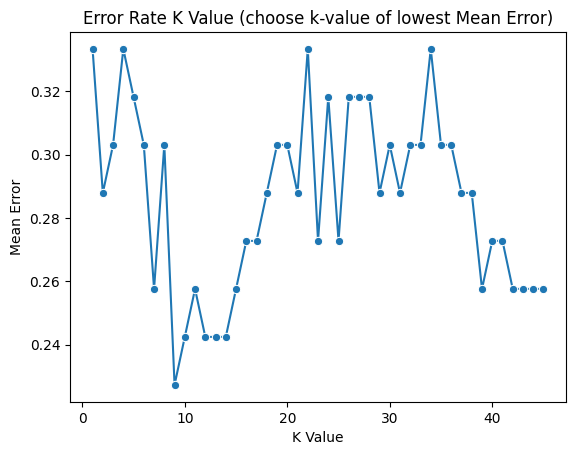

In [2696]:
# CLASSIFIER VERSION
# adjust this to 50 or even 150 if you have lots of data rows
max_iterations = 46

# list to save the error values in the loop
error = []

# the default metric in scikit-learn
metric_selection = "cosine"
weight_selection = 'uniform'

# Calculating error for K values between 1 and 40
for i in range(1, max_iterations):

     # try with current k-value, train the model and make a test prediction
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=i, weights=weight_selection, metric=metric_selection))
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)

    # save the error value for this k-value
    error.append(np.mean(pred_i != y_test))
    
# plot all the k-values and their error values
sns.lineplot(x=range(1, max_iterations), y=error, marker='o')
plt.title('Error Rate K Value (choose k-value of lowest Mean Error)')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# choose best k-value based on metrics
# we have to add +1 to k-value, since argmin() returns an index
# which starts from 0, but k-values start from 1
print("Based on iterations, best k-value is this:")
k_value = np.argmin(error) + 1
print(k_value)

### Create logistic regression model

In [2697]:

# model = LogisticRegression()
# model.fit(X_train, y_train)

# build the model with the optimal values
model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k_value, metric=metric_selection))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='cosine', n_neighbors=9))])

### Classification error metrics

In [2698]:
 # get the test predictions for metrics as usual
predictions = model.predict(X_test)

In [ ]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))
# the best results i got with the following parameters:k-value = 46 or 139 -> the accuracy is 80%.

              precision    recall  f1-score   support

           0       0.76      0.82      0.79        34
           1       0.79      0.72      0.75        32

    accuracy                           0.77        66
   macro avg       0.77      0.77      0.77        66
weighted avg       0.77      0.77      0.77        66


Model overall accuracy: 77.27%


[[28  6]
 [ 9 23]]


<Axes: >

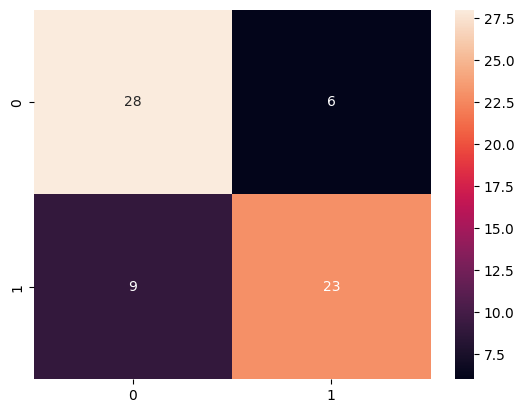

In [2700]:
print(confusion_matrix(y_test, predictions))

# if you want a more graphical version of this, try:
# the fmt-parameter will change to decimal format from scientific format
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

In [2701]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary logistic regression, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multinomial logistic regression , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# basically 0.5 means, there's still something to optimize
# if this falls under 0.5, random guessing works better than this model
roc_auc_score(y, model.predict_proba(X.values)[:, 1])

c:\Users\svetl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


0.8017843615857252

### Let's use the model in practice:

In [2702]:
df.columns

Index(['sex', 'famsize', 'Pstatus', 'traveltime', 'studytime', 'failures',
       'higher', 'goout', 'health', 'absences', 'high_alcohol_use'],
      dtype='object')

In [2703]:
df.head(1)

,sex,famsize,Pstatus,traveltime,studytime,failures,higher,goout,health,absences,high_alcohol_use
0,0,0,1,1,2,0,1,4,5,0,0


In [ ]:
# Sex -column: 0 => Female, 1 => Male
tester_row = {
    'sex':1,
    'famsize':0,
    'Pstatus':1,
    'traveltime':1,
    'studytime':2,
    'failures':1,
    'higher':1,
    'goout':5,
    'health':5,
    'absences':1
}

# create a pandas DataFrame and scale the values
tester_row = pd.DataFrame([tester_row])

# scaling is done in the Pipeline instead
# we don't have use this anymore
# tester_row = sc.transform(tester_row)

print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Does the student have high alcohol consumption? (No/Yes):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.22222222 0.77777778]]

Does the student have high alcohol consumotion? (No/Yes):
Yes
-------------------


### The best accuracy i got is 80%, Random forest ML model gave 81%. Model runs very fast, because it doesn't have training phase, it should be good for small and simply datasets. There is not so many optimization options, the same as with Random Forest, I optimized only the k-value and tried with random_state or without.The KNN algorithm is best suited for small, limited datasets with balanced target variables.